In [1]:
import pyemma
import pickle
import os
import glob
import torch

import mdtraj as md
import numpy as np
import nglview as nv
import matplotlib.pyplot as plt
import numpy as np

np.bool = np.bool_

from tqdm import tqdm
from matplotlib.colors import LogNorm
from itertools import combinations

blue = (70 / 255, 110 / 255, 250 / 255)
green = (100 / 255, 170 / 255, 120 / 255)

In [2]:
molecule = "GTT"
simulation_idx = 0
base_dir = f"/home/shpark/prj-mlcv/lib/DESRES/DESRES-Trajectory_{molecule}-{simulation_idx}-protein/{molecule}-{simulation_idx}-protein"
save_dir = f"/home/shpark/prj-mlcv/lib/DESRES/DESRES-Trajectory_{molecule}-{simulation_idx}-protein"
pdb_path = f"/home/shpark/prj-mlcv/lib/DESRES/data/{molecule}/{molecule}_from_mae.pdb"

# Strings

In [3]:
name2letter = {
	"ALA": "A",
	"CYS": "C",
	"ASP": "D",
	"GLU": "E",
	"PHE": "F",
	"GLY": "G",
	"HIS": "H",
	"ILE": "I",
	"LYS": "K",
	"LEU": "L",
	"MET": "M",
	"ASN": "N",
	"PRO": "P",
	"GLN": "Q",
	"ARG": "R",
	"SER": "S",
	"THR": "T",
	"VAL": "V",
	"TRP": "W",
	"TYR": "Y",
	"NLE": "X",
}

pdb_traj = md.load_pdb(pdb_path) 
residue_names = [residue.name for residue in pdb_traj.topology.residues]
one_letter_str = ""
for idx, names in enumerate(residue_names):
    # print(f"Letter {idx}: {name2letter[names]}")
    one_letter_str += name2letter[names]
print(one_letter_str)
print(len(one_letter_str))

GSKLPPGWEKRMSRDGRVYYFNHITGTTQFERPSG
35


In [4]:
# CA atom index
ca_atoms = [atom for atom in pdb_traj.topology.atoms if atom.name == "CA"]
ca_indices = [atom.index for atom in ca_atoms]

cnt = 1
for i in range(len(ca_indices)):
    for j in range(i+1, len(ca_indices)):
        print(f"d{cnt}: DISTANCE ATOMS={ca_indices[i]+1},{ca_indices[j]+1}")
        cnt += 1

print("ARG=" + ",".join(f"d{i+1}" for i in range(cnt)))

d1: DISTANCE ATOMS=2,11
d2: DISTANCE ATOMS=2,22
d3: DISTANCE ATOMS=2,44
d4: DISTANCE ATOMS=2,63
d5: DISTANCE ATOMS=2,77
d6: DISTANCE ATOMS=2,91
d7: DISTANCE ATOMS=2,98
d8: DISTANCE ATOMS=2,122
d9: DISTANCE ATOMS=2,137
d10: DISTANCE ATOMS=2,159
d11: DISTANCE ATOMS=2,183
d12: DISTANCE ATOMS=2,200
d13: DISTANCE ATOMS=2,211
d14: DISTANCE ATOMS=2,235
d15: DISTANCE ATOMS=2,247
d16: DISTANCE ATOMS=2,254
d17: DISTANCE ATOMS=2,278
d18: DISTANCE ATOMS=2,294
d19: DISTANCE ATOMS=2,315
d20: DISTANCE ATOMS=2,336
d21: DISTANCE ATOMS=2,356
d22: DISTANCE ATOMS=2,370
d23: DISTANCE ATOMS=2,387
d24: DISTANCE ATOMS=2,406
d25: DISTANCE ATOMS=2,420
d26: DISTANCE ATOMS=2,427
d27: DISTANCE ATOMS=2,441
d28: DISTANCE ATOMS=2,455
d29: DISTANCE ATOMS=2,472
d30: DISTANCE ATOMS=2,492
d31: DISTANCE ATOMS=2,507
d32: DISTANCE ATOMS=2,531
d33: DISTANCE ATOMS=2,545
d34: DISTANCE ATOMS=2,556
d35: DISTANCE ATOMS=11,22
d36: DISTANCE ATOMS=11,44
d37: DISTANCE ATOMS=11,63
d38: DISTANCE ATOMS=11,77
d39: DISTANCE ATOMS=11,91
d4

# Visualization

In [5]:
# PDB
pdb_traj = md.load_pdb(pdb_path)
pdb_view = nv.show_mdtraj(
    pdb_traj,
    height="400px",
    width="400px"
)
pdb_view.add_representation("licorice", selection="protein")

print(pdb_traj)
pdb_view

<mdtraj.Trajectory with 1 frames, 562 atoms, 35 residues, and unitcells>


NGLWidget()

In [6]:
# Check .dcd files in the simulation directory
dcd_pattern = f"{base_dir}/{molecule}-{simulation_idx}-protein-*-aligned.dcd"
dcd_files = glob.glob(dcd_pattern)
num_files = len(dcd_files)
print(f"Found {num_files} .dcd files in {base_dir}")
print(f"Pattern used: {dcd_pattern}")

file_indices = []
for file_path in dcd_files:
    filename = os.path.basename(file_path)
    index_part = filename.split('-')[-2].replace('.dcd', '')
    if index_part.isdigit():
        file_indices.append(int(index_part))

file_indices.sort()
print(f"File indices range: {min(file_indices)} to {max(file_indices)}")
print(f"Total files to load: {len(file_indices)}")

Found 244 .dcd files in /home/shpark/prj-mlcv/lib/DESRES/DESRES-Trajectory_GTT-0-protein/GTT-0-protein
Pattern used: /home/shpark/prj-mlcv/lib/DESRES/DESRES-Trajectory_GTT-0-protein/GTT-0-protein/GTT-0-protein-*-aligned.dcd
File indices range: 0 to 243
Total files to load: 244


In [7]:
# Load trajectories 
traj_list = []
for i in tqdm(
    file_indices,
    desc="Loading trajectories"
):
    file_idx = f"{i:03d}"
    file_path = f"{base_dir}/{molecule}-{simulation_idx}-protein-{file_idx}-aligned.dcd"
    if os.path.exists(file_path):
        traj = md.load_dcd(file_path, top=pdb_path)
        traj_list.append(traj)
    else:
        print(f"Warning: File not found: {file_path}")

print(f"Successfully loaded {len(traj_list)} trajectory files")
all_traj = md.join(traj_list)

Loading trajectories: 100%|██████████| 244/244 [00:16<00:00, 14.58it/s]


Successfully loaded 244 trajectory files


In [43]:
all_traj.center_coordinates()
print(all_traj)
view = nv.show_mdtraj(
    all_traj,
	height="400px",
    width="400px"
)
view.add_representation("licorice", selection="protein")
print(f"Total frames: {all_traj.n_frames}")
view

<mdtraj.Trajectory with 2432586 frames, 562 atoms, 35 residues, and unitcells>
Total frames: 2432586


NGLWidget(max_frame=2432585)

In [62]:
view.frame = 924382

In [ ]:
file_idx = "000"
file_path = f"{base_dir}/{molecule}-{simulation_idx}-protein-{file_idx}.dcd"
test_pdb_path = f"/home/shpark/prj-mlcv/lib/DESRES/data/{molecule}/{molecule}.pdb"
test_traj = md.load_dcd(file_path, top=test_pdb_path)
print(test_traj)

test_view = nv.show_mdtraj(
    test_traj,
    height="400px",
    width="400px"
)
test_view.add_representation("licorice", selection="protein")
test_view


<mdtraj.Trajectory with 10000 frames, 562 atoms, 38 residues, and unitcells>


NGLWidget(max_frame=9999)

In [45]:
test_view.frame = 189468

# Descriptors

In [7]:
pdb_traj = md.load(pdb_path)
ca_resid_pair = np.array(
	[(a.index, b.index) for a, b in combinations(list(pdb_traj.topology.residues), 2)]
)

# ca_pair_contacts, resid_pairs = md.compute_contacts(
# 	all_traj, scheme="ca", contacts=ca_resid_pair, periodic=False
# )
# torch.save(
#     torch.from_numpy(ca_pair_contacts),
#     f"../DESRES-Trajectory_{molecule}-{simulation_idx}-protein/{molecule}-{simulation_idx}-cad.pt"
# )

ca_pair_contacts = torch.load(
	f"../DESRES-Trajectory_{molecule}-{simulation_idx}-protein/{molecule}-{simulation_idx}-cad.pt"
).numpy()
print(ca_pair_contacts.shape)
print(ca_pair_contacts.mean())

(2432586, 595)
1.3621553


In [8]:
# exp = 2
# ca_pair_distances_swtich = (1 - (np.power(ca_pair_contacts, exp) / 0.8)) / (1 - (np.power(ca_pair_contacts, exp) / 0.8))
# torch.save(
#     torch.from_numpy(ca_pair_distances_swtich),
#     f"../DESRES-Trajectory_{molecule}-{simulation_idx}-protein/{molecule}-{simulation_idx}-cad-switch.pt"
# )

ca_pair_distances_swtich = torch.load(
	f"../DESRES-Trajectory_{molecule}-{simulation_idx}-protein/{molecule}-{simulation_idx}-cad-switch.pt"
).numpy()
print(ca_pair_distances_swtich.shape)
print(ca_pair_distances_swtich.mean())

(2432586, 595)
1.0


In [9]:
# xyz = all_traj.xyz
# torch.save(
#     torch.from_numpy(xyz),
#     f"../DESRES-Trajectory_{molecule}-{simulation_idx}-protein/{molecule}-{simulation_idx}-pos.pt"
# )

xyz = torch.load(f"../DESRES-Trajectory_{molecule}-{simulation_idx}-protein/{molecule}-{simulation_idx}-pos.pt").numpy()
print(xyz.shape)

(2432586, 562, 3)


# TICA

In [27]:
def cad2switch(
    cad,
    cutoff: float = 0.8
) -> np.ndarray:
	if type(cad) == torch.Tensor:
		cad = cad.numpy()
	return (1 - np.power(cad / cutoff, 6)) / (1 - np.power(cad / cutoff, 12))

/home/shpark/.conda/envs/bioemu/lib/python3.10/site-packages/decorator.py:235: PyEMMA_DeprecationWarning: Call to deprecated function "tica". Called from /home/shpark/.conda/envs/bioemu/lib/python3.10/site-packages/decorator.py line 235. Use deeptime.decomposition.TICA instead.
  return caller(func, *(extras + args), **kw)


calculate covariances:   0%|          | 0/22 [00:00<?, ?it/s]

getting output of TICA:   0%|          | 0/22 [00:00<?, ?it/s]

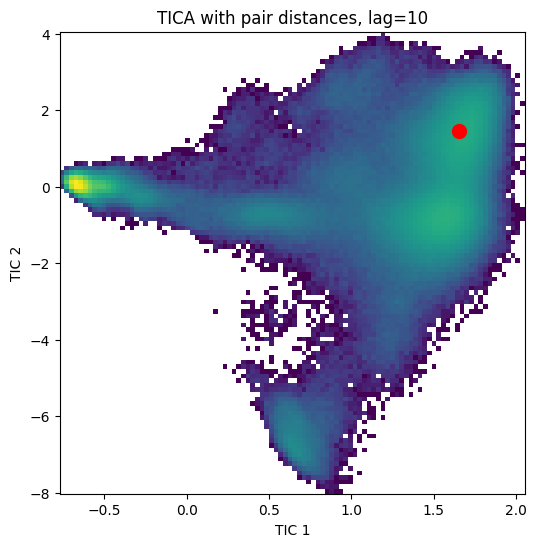

/home/shpark/.conda/envs/bioemu/lib/python3.10/site-packages/decorator.py:235: PyEMMA_DeprecationWarning: Call to deprecated function "tica". Called from /home/shpark/.conda/envs/bioemu/lib/python3.10/site-packages/decorator.py line 235. Use deeptime.decomposition.TICA instead.
  return caller(func, *(extras + args), **kw)


calculate covariances:   0%|          | 0/22 [00:00<?, ?it/s]

getting output of TICA:   0%|          | 0/22 [00:00<?, ?it/s]

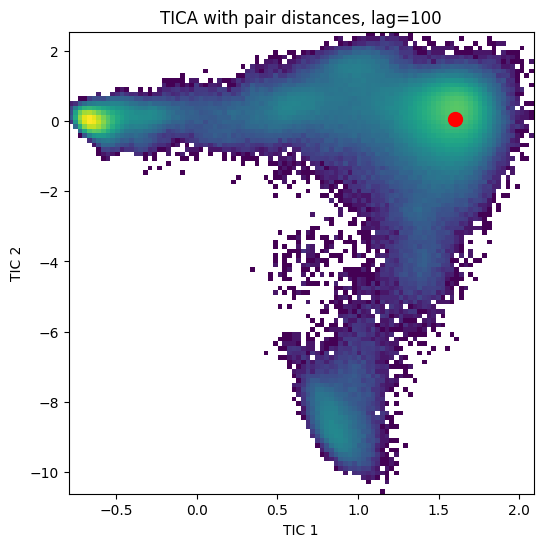

/home/shpark/.conda/envs/bioemu/lib/python3.10/site-packages/decorator.py:235: PyEMMA_DeprecationWarning: Call to deprecated function "tica". Called from /home/shpark/.conda/envs/bioemu/lib/python3.10/site-packages/decorator.py line 235. Use deeptime.decomposition.TICA instead.
  return caller(func, *(extras + args), **kw)


calculate covariances:   0%|          | 0/22 [00:00<?, ?it/s]

getting output of TICA:   0%|          | 0/22 [00:00<?, ?it/s]

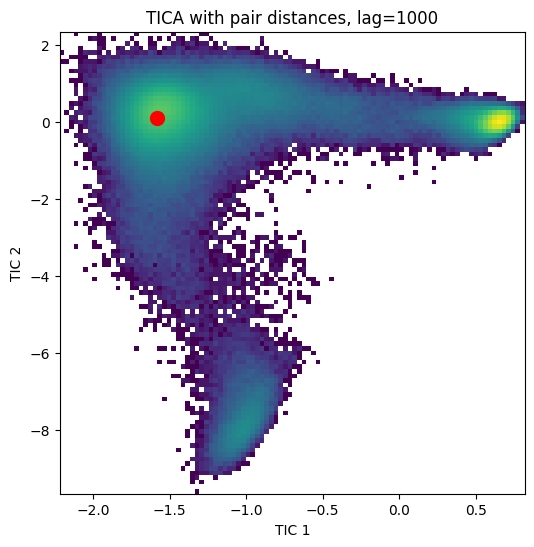

In [28]:
# TICA with pair distances
pdb_state = md.load(pdb_path)
pdb_state_ca_pair_distances, pdb_resid_pairs = md.compute_contacts(pdb_state, scheme="ca", contacts=ca_resid_pair, periodic=False)

for lag in (10, 100, 1000):
	tica_coord_path = f"../data/{molecule}/{molecule}_tica_coord_lag{lag}.npy"
	if os.path.exists(tica_coord_path):
		tica_data = np.load(tica_coord_path)
	else:
		tica_obj = pyemma.coordinates.tica(ca_pair_contacts, lag=lag, dim=2)
		tica_data = tica_obj.get_output()[0]
		np.save(tica_coord_path, tica_data)
	x = tica_data[:, 0]
	y = tica_data[:, 1]

	pdb_tica_data = tica_obj.transform(pdb_state_ca_pair_distances)
	pdb_tica_x = pdb_tica_data[:, 0]
	pdb_tica_y = pdb_tica_data[:, 1]

	# Plot
	fig = plt.figure(figsize=(6, 6))
	ax = fig.add_subplot(111)
	ax.hist2d(x, y, bins=100, norm=LogNorm())
	ax.scatter(pdb_tica_x, pdb_tica_y, color="red", s=100)
	ax.set_xlabel("TIC 1")
	ax.set_ylabel("TIC 2")
	plt.title(f"TICA with pair distances, lag={lag}")
	plt.savefig(f'../data/{molecule}/{molecule}_tica_model_lag{lag}.png')
	plt.show()
	plt.close()

	with open(f'../data/{molecule}/{molecule}_tica_model_lag{lag}.pkl', 'wb') as f:
		pickle.dump(tica_obj, f)

In [ ]:
# TICA with pair distances switch
pdb_state = md.load(pdb_path)
pdb_state_ca_pair_distances, pdb_resid_pairs = md.compute_contacts(pdb_state, scheme="ca", contacts=ca_resid_pair, periodic=False)
pdb_state_ca_pair_distances = cad2switch(pdb_state_ca_pair_distances)
data_switch = cad2switch(ca_pair_contacts)

for lag in (10, 100, 1000):
	tica_obj = pyemma.coordinates.tica(data_switch, lag=lag, dim=2)
	tica_data = tica_obj.get_output()[0]
	x = tica_data[:, 0]
	y = tica_data[:, 1]

	pdb_tica_data = tica_obj.transform(pdb_state_ca_pair_distances)
	pdb_tica_x = pdb_tica_data[:, 0]
	pdb_tica_y = pdb_tica_data[:, 1]

	# Plot
	fig = plt.figure(figsize=(6, 6))
	ax = fig.add_subplot(111)
	ax.hist2d(x, y, bins=100, norm=LogNorm())
	ax.scatter(pdb_tica_x, pdb_tica_y, color="red", s=100)
	ax.set_xlabel("TIC 1")
	ax.set_ylabel("TIC 2")
	plt.title(f"TICA with pair distances, lag={lag}")
	plt.savefig(f'../data/{molecule}/{molecule}_tica_model_switch_lag{lag}.png')
	plt.show()
	plt.close()

	with open(f'../data/{molecule}/{molecule}_tica_model_switch_lag{lag}.pkl', 'wb') as f:
		pickle.dump(tica_obj, f)

/tmp/ipykernel_780512/1269659341.py:7: RuntimeWarning: invalid value encountered in divide
  return (1 - np.power(cad / cutoff, 6)) / (1 - np.power(cad / cutoff, 12))
/home/shpark/.conda/envs/bioemu/lib/python3.10/site-packages/decorator.py:235: PyEMMA_DeprecationWarning: Call to deprecated function "tica". Called from /home/shpark/.conda/envs/bioemu/lib/python3.10/site-packages/decorator.py line 235. Use deeptime.decomposition.TICA instead.
  return caller(func, *(extras + args), **kw)


calculate covariances:   0%|          | 0/22 [00:00<?, ?it/s]

InvalidDataInStreamException: Found invalid values in chunk in trajectory index 0 at chunk [112798, 225586] within frames (array([ 35921, 110250]), array([416, 128])).

: 

In [ ]:
lag = 10
tica_coord_path = f"../data/{molecule}/{molecule}_tica_coord_lag{lag}.npy"
tica_coord_loaded = np.load(tica_coord_path)
print(tica_coord_loaded.shape)

# Analysis

## States by RMSD

In [8]:
def rmsd_to_refpdb(
	traj: md.Trajectory,
	reference_traj: md.Trajectory,
	atom_type: str = "ca",
) -> np.ndarray:
	"""
	Generate binary labels for folded/unfolded states based on RMSD
	"""
	if atom_type == "ca":
		atom_indices = traj.topology.select("name CA")
	else:
		atom_indices = None
	
	rmsd = md.rmsd(
		target = traj,
		reference = reference_traj,
		atom_indices = atom_indices
	)
	return rmsd

### Folded

0.5054074


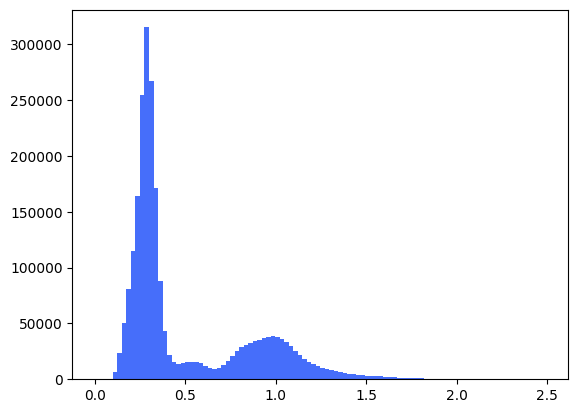

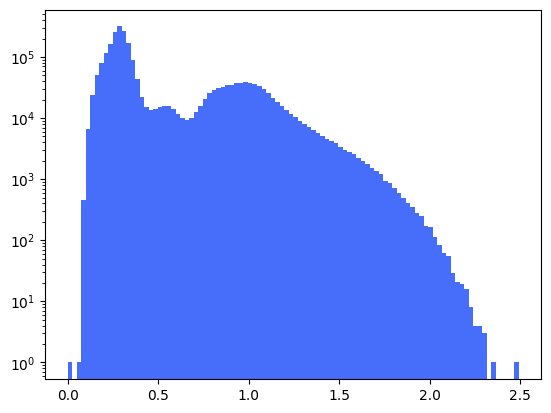

In [9]:
selected_frame = all_traj[2180330]
rmsd_to_folded = rmsd_to_refpdb(
    traj = all_traj,
    reference_traj = selected_frame,
)

print(rmsd_to_folded.mean())
plt.hist(
    rmsd_to_folded,
    bins=100,
    # log=True,
    color=blue,
)
plt.show()

plt.hist(
    rmsd_to_folded,
    bins=100,
    log=True,
    color=blue,
)
plt.show()

In [59]:
np.argwhere((rmsd_to_folded > 0.95) & (rmsd_to_folded < 1.05))

array([[      1],
       [     14],
       [     16],
       ...,
       [1324317],
       [1324615],
       [1325054]], shape=(151066, 1))

In [10]:
dssp_selected = md.compute_dssp(selected_frame)
print(dssp_selected.shape)
print(dssp_selected[0])
e_counts_per_frame = (dssp_selected == 'E').sum(axis=1)
print(e_counts_per_frame)
view_selected = nv.show_mdtraj(selected_frame)
view_selected.add_representation("licorice", selection="protein")
view_selected

(1, 35)
['C' 'C' 'C' 'C' 'C' 'C' 'C' 'E' 'E' 'E' 'E' 'E' 'C' 'C' 'C' 'C' 'C' 'E'
 'E' 'E' 'E' 'E' 'C' 'C' 'C' 'C' 'C' 'E' 'E' 'C' 'C' 'C' 'C' 'C' 'C']
[12]


NGLWidget()

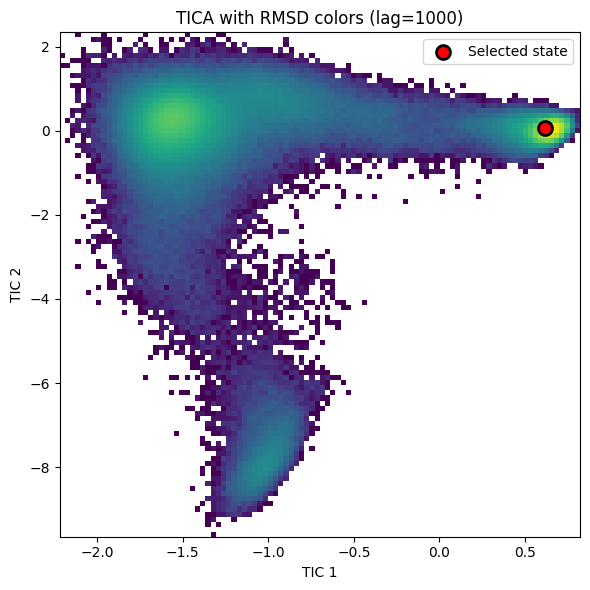

In [11]:
# pdb on TICA plot
lag = 1000

ca_resid_pair = np.array(
	[(a.index, b.index) for a, b in combinations(list(all_traj.topology.residues), 2)]
)
selected_ca_pair_distances, resid_pairs = md.compute_contacts(
	selected_frame, scheme="ca", contacts=ca_resid_pair, periodic=False
)
tica_model_path = f"../data/{molecule}/{molecule}_tica_model_lag{lag}.pkl"
tica_model = pickle.load(open(tica_model_path, 'rb'))
tica_data_selected = tica_model.transform(selected_ca_pair_distances)
x_tica_selected = tica_data_selected[:, 0]
y_tica_selected = tica_data_selected[:, 1]

tica_coord_path = f"../data/{molecule}/{molecule}_tica_coord_lag{lag}.npy"
tica_data = np.load(tica_coord_path)
x = tica_data[:, 0]
y = tica_data[:, 1]

# Plot TICA with RMSD colors
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
ax.hist2d(x, y, bins=100, norm=LogNorm())
ax.scatter(
    x_tica_selected,
    y_tica_selected,
    c="red",
    s=100,
    edgecolors="k",
    linewidths=2,
    label="Selected state",
)
ax.set_xlabel("TIC 1")
ax.set_ylabel("TIC 2")
ax.set_title(f"TICA with RMSD colors (lag={lag})")
ax.legend(loc="best")
plt.tight_layout()
plt.show()
plt.close()


In [12]:
rmsd_threshold = 0.7
save_dir = f"/home/shpark/prj-mlcv/lib/DESRES/DESRES-Trajectory_{molecule}-{simulation_idx}-protein"

selected_frame.save_pdb(
	f"/home/shpark/prj-mlcv/lib/DESRES/data/{molecule}/folded.pdb"
)
# torch.save(
#     torch.from_numpy(rmsd_to_folded),
#     f"{save_dir}/{molecule}-{simulation_idx}-rmsd.pt"
# )
# torch.save(
#     torch.from_numpy(rmsd_to_folded < rmsd_threshold),
#     f"{save_dir}/{molecule}-{simulation_idx}-label-rmsd-folded.pt"
# )

### Unfolded

1.2265576


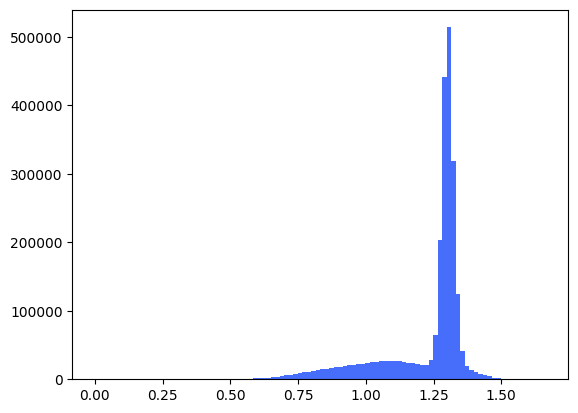

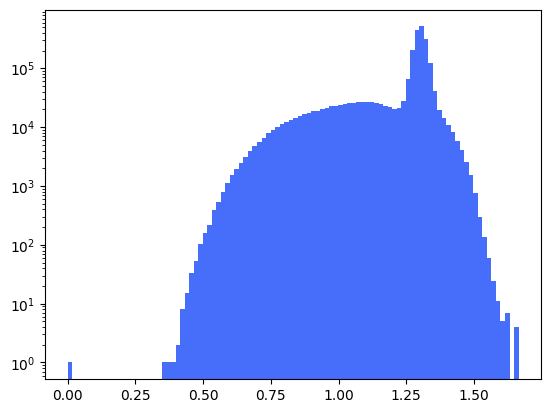

In [13]:
unfolded_selected_frame = all_traj[10]
unfolded_selected_rmsd = rmsd_to_refpdb(
    traj = all_traj,
    reference_traj = unfolded_selected_frame,
)

print(unfolded_selected_rmsd.mean())
plt.hist(
    unfolded_selected_rmsd,
    bins=100,
    # log=True,
    color=blue,
)
plt.show()

plt.hist(
    unfolded_selected_rmsd,
    bins=100,
    log=True,
    color=blue,
)
plt.show()

In [14]:
unfolded_dssp_selected = md.compute_dssp(unfolded_selected_frame)
print(unfolded_dssp_selected.shape)
print(unfolded_dssp_selected[0])
unfolded_selected_view = nv.show_mdtraj(unfolded_selected_frame)
unfolded_selected_view.add_representation("licorice", selection="protein")
unfolded_selected_view

(1, 35)
['C' 'C' 'C' 'C' 'C' 'H' 'H' 'H' 'H' 'H' 'H' 'C' 'C' 'C' 'C' 'H' 'H' 'H'
 'H' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C']


NGLWidget()

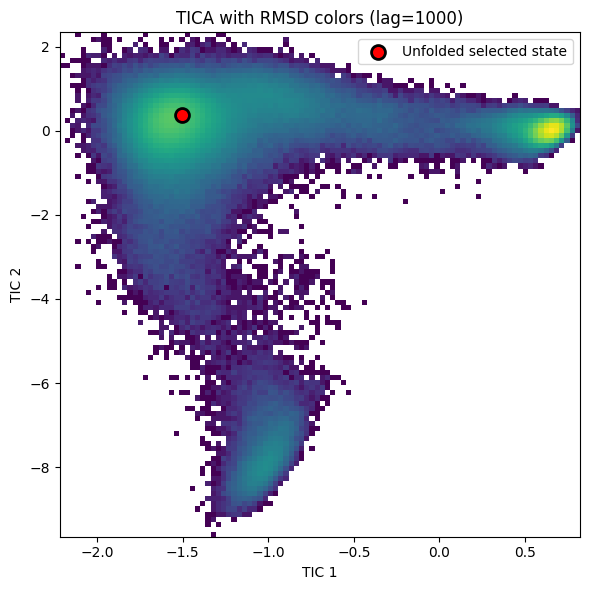

In [15]:
# pdb on TICA plot
lag = 1000

ca_resid_pair = np.array(
	[(a.index, b.index) for a, b in combinations(list(all_traj.topology.residues), 2)]
)
unfolded_ca_pair_distances, resid_pairs = md.compute_contacts(
	unfolded_selected_frame, scheme="ca", contacts=ca_resid_pair, periodic=False
)
tica_model_path = f"../data/{molecule}/{molecule}_tica_model_lag{lag}.pkl"
tica_model = pickle.load(open(tica_model_path, 'rb'))
tica_data_selected = tica_model.transform(unfolded_ca_pair_distances)
x_tica_selected = tica_data_selected[:, 0]
y_tica_selected = tica_data_selected[:, 1]

tica_coord_path = f"../data/{molecule}/{molecule}_tica_coord_lag{lag}.npy"
tica_data = np.load(tica_coord_path)
x = tica_data[:, 0]
y = tica_data[:, 1]

# Plot TICA with RMSD colors
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
ax.hist2d(x, y, bins=100, norm=LogNorm())
ax.scatter(
    x_tica_selected,
    y_tica_selected,
    c="red",
    s=100,
    edgecolors="k",
    linewidths=2,
    label="Unfolded selected state",
)
ax.set_xlabel("TIC 1")
ax.set_ylabel("TIC 2")
ax.set_title(f"TICA with RMSD colors (lag={lag})")
ax.legend(loc="best")
plt.tight_layout()
plt.show()
plt.close()


In [16]:
save_dir = f"/home/shpark/prj-mlcv/lib/DESRES/DESRES-Trajectory_{molecule}-{simulation_idx}-protein"

unfolded_selected_frame.save_pdb(
	f"/home/shpark/prj-mlcv/lib/DESRES/data/{molecule}/unfolded.pdb"
)
# torch.save(
#     torch.from_numpy(unfolded_selected_rmsd),
#     f"{save_dir}/{molecule}-{simulation_idx}-rmsd_unfolded.pt"
# )

# Conclusion